In [1]:
import os
import sys

codebase_path = os.path.abspath("./codebase")
if codebase_path not in sys.path:
    sys.path.append(codebase_path)
    
import torch.backends.cudnn as cudnn
import random
import time
from collections import OrderedDict
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.functional import one_hot
import sklearn.metrics as metrics
import utils
from Explainer.loss_F import loss_fn_kd, entropy_loss
from Explainer.models.Gated_Logic_Net import Gated_Logic_Net
from Explainer.models.explainer import Explainer
from Explainer.models.pi import Pi
from dataset.dataset_cubs import Dataset_cub_for_explainer
from dataset.utils_dataset import get_dataset_with_image_and_attributes
from Explainer.loss_F import loss_fn_kd, entropy_loss, Selective_Distillation_Loss
from Explainer.models.concepts import Conceptizator

import matplotlib.pyplot as plt

In [2]:
device = utils.get_device()
print(f"Device: {device}")

Device: cpu


In [8]:
lr = 0.01
cov = 0.2
pickle_in = open(
    os.path.join(
        f"/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/explainer/test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr)
print(args.cov)

########################
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2]


In [36]:
print(args.arch)
print(args.layer)

print(args.checkpoint_model)
print(args.checkpoint_residual)

print(args.iter)

ResNet101
layer4
['model_g_best_model_epoch_64.pth.tar', 'model_g_best_model_epoch_188.pth.tar', 'model_g_best_model_epoch_110.pth.tar', 'model_g_best_model_epoch_257.pth.tar', 'model_g_best_model_epoch_345.pth.tar', 'model_g_best_model_epoch_87.pth.tar', 'model_g_best_model_epoch_114.pth.tar', 'model_g_best_model_epoch_86.pth.tar']
['model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar', 'model_residual_best_model_epoch_1.pth.tar']
8


<IPython.core.display.Javascript object>

In [9]:
use_concepts_as_pi_input = True
explainer_init = "none"
cov = args.cov[0]
experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{cov}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

print(experiment_folder)

lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none


In [16]:
lr = 0.01
cov = 0.2
pickle_in = open(
    os.path.join(
        f"/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/iter1/explainer/test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr)
print(args.cov)

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub"
experiment = "explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none"
iteration = "iter1"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds.pt"
    )
)

test_tensor_preds_bb_1 = torch.load(
    os.path.join(
        root, experiment, iteration, expert_type, output, "test_tensor_preds_bb.pt"
    )
)

test_tensor_y_1 = torch.load(
    os.path.join(root, experiment, iteration, expert_type, output, "test_tensor_y.pt")
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_1.size())
print(test_tensor_preds_bb_1.size())
print(test_tensor_y_1.size())

########################
[0.01]
[0.2]


 << Test sizes >>
torch.Size([220, 200])
torch.Size([220, 200])
torch.Size([220])


In [18]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter2/explainer/test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub"
experiment = "explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none"
iteration = "iter2"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_2 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_2.size())
print(test_tensor_preds_bb_2.size())
print(test_tensor_y_2.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([224, 200])
torch.Size([224, 200])
torch.Size([224])


In [19]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter3/explainer/test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub"
experiment = "explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none"
iteration = "iter3"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_3 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_3.size())
print(test_tensor_preds_bb_3.size())
print(test_tensor_y_3.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([167, 200])
torch.Size([167, 200])
torch.Size([167])


In [25]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter4/explainer/test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub"
experiment = "explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none"
iteration = "iter4"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_4 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_4.size())
print(test_tensor_preds_bb_4.size())
print(test_tensor_y_4.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([151, 200])
torch.Size([151, 200])
torch.Size([151])


In [26]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter5/explainer/test_explainer_configs.pkl",
    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub"
experiment = "explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none"
iteration = "iter5"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_5 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_5.size())
print(test_tensor_preds_bb_5.size())
print(test_tensor_y_5.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([272, 200])
torch.Size([272, 200])
torch.Size([272])


In [27]:
base_lr = 0.01
base_cov = 0.2
pickle_in = open(
    os.path.join(
        f"/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/explainer/test_explainer_configs.pkl",

    ),
    "rb",
)
args = pickle.load(pickle_in)
n_classes = len(args.labels)
x_to_bool = 0.5
top_k_explanations = 50
concept_names = args.concept_names
print("########################")
print(args.lr[-1])
print(args.cov[-1])

use_concepts_as_pi_input = True
explainer_init = "none"

experiment_folder = (
    f"lr_{args.lr[0]}_epochs_{args.epochs}_temperature-lens_{args.temperature_lens}"
    f"_use-concepts-as-pi-input_{use_concepts_as_pi_input}_input-size-pi_{args.input_size_pi}"
    f"_cov_{args.cov[0]}_alpha_{args.alpha}_selection-threshold_{args.selection_threshold}"
    f"_lambda-lens_{args.lambda_lens}_alpha-KD_{args.alpha_KD}"
    f"_temperature-KD_{float(args.temperature_KD)}_hidden-layers_{len(args.hidden_nodes)}"
    f"_layer_{args.layer}_explainer_init_{explainer_init if not args.explainer_init else args.explainer_init}"
)

root = "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub"
experiment = "explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none"
iteration = "iter6"
expert_type = "explainer"
output = "g_outputs"


test_tensor_preds_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds.pt",
    )
)

test_tensor_preds_bb_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_preds_bb.pt",
    )
)

test_tensor_y_6 = torch.load(
    os.path.join(
        root,
        experiment,
        "cov_0.2_lr_0.01",
        iteration,
        expert_type,
        output,
        "test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_6.size())
print(test_tensor_preds_bb_6.size())
print(test_tensor_y_6.size())


########################
0.01
0.2


 << Test sizes >>
torch.Size([147, 200])
torch.Size([147, 200])
torch.Size([147])


In [38]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, test_tensor_preds_5, test_tensor_preds_6, 
#                    test_tensor_preds_7,  
#                    test_tensor_preds_8
                  ), dim=0)
gt = torch.cat((
    test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,test_tensor_y_4, test_tensor_y_5, test_tensor_y_6,
#                test_tensor_y_7, 
#     test_tensor_y_8
               ),
               dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(), test_tensor_preds_bb_5.cpu(), test_tensor_preds_bb_6.cpu(), 
#     test_tensor_preds_bb_7.cpu(),
#     test_tensor_preds_bb_8.cpu()
), 
               dim=0)


In [29]:
torch.sum(preds.argmax(dim=1) == gt) / gt.size(0), gt.size()

(tensor(0.8112), torch.Size([1181]))

In [31]:
(
    test_tensor_preds_1.size(0) / 1183,
    test_tensor_preds_2.size(0) / (1183 - test_tensor_preds_1.size(0)),
    test_tensor_preds_3.size(0)
    / (1183 - test_tensor_preds_2.size(0) - test_tensor_preds_1.size(0)),
    test_tensor_preds_4.size(0)
    / (
        1183
        - test_tensor_preds_3.size(0)
        - test_tensor_preds_2.size(0)
        - test_tensor_preds_1.size(0)
    ),
    test_tensor_preds_5.size(0)
    / (
        1183
        - test_tensor_preds_4.size(0)
        - test_tensor_preds_3.size(0)
        - test_tensor_preds_2.size(0)
        - test_tensor_preds_1.size(0)
    ),
    test_tensor_preds_6.size(0)
    / (
        1183
        - test_tensor_preds_5.size(0)
        - test_tensor_preds_4.size(0)
        - test_tensor_preds_3.size(0)
        - test_tensor_preds_2.size(0)
        - test_tensor_preds_1.size(0)
    ),
    # test_tensor_preds_7.size(0)
    # / (
    #     1183
    #     - test_tensor_preds_6.size(0)
    #     - test_tensor_preds_5.size(0)
    #     - test_tensor_preds_4.size(0)
    #     - test_tensor_preds_3.size(0)
    #     - test_tensor_preds_2.size(0)
    #     - test_tensor_preds_1.size(0)
    # ),
)

(0.18596787827557057,
 0.23260643821391486,
 0.2259810554803789,
 0.263986013986014,
 0.6460807600950119,
 0.9865771812080537)

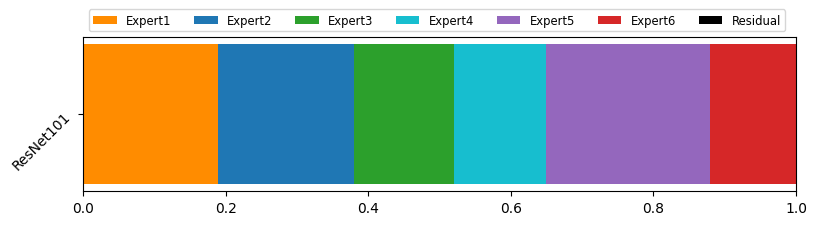

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Updated category names (6 experts + Residual)
category_names = [
    "Expert1",
    "Expert2",
    "Expert3",
    "Expert4",
    "Expert5",
    "Expert6",
    "Residual",
]

# Updated results matching the 6 experts + residual
results = {
    "ResNet101": [0.19, 0.19, 0.14, 0.13, 0.23, 0.12, 0.00],
}


def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    
    # Updated colors (7 colors)
    category_colors = [
        "darkorange",
        "tab:blue",
        "tab:green",
        "tab:cyan",
        "tab:purple",
        "tab:red",
        "black",
    ]

    fig, ax = plt.subplots(figsize=(9.2, 2))
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 1),
        loc="lower left",
        fontsize="small",
    )

    for tick in ax.get_yticklabels():
        tick.set_rotation(45)
    return fig, ax


survey(results, category_names)
plt.show()


Note: We are not using code below this line but we might need it for additional graphs. Could possibly delete.

In [40]:
preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 1183


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {1183})")
print(f"total coverage by g: {g_tot_cov}")

g_tot_acc: 81.11769686706182 (%)
bb_tot_acc: 88.56900931414056 (%)
g_tot_f1: 81.11769686706182 (%)
g_tot_precision: 81.11769686706182 (%)
g_tot_recall: 81.11769686706182 (%)
bb_tot_recall: 88.56900931414056 (%)
total samples covered by g: 1181 (out of 1183)
total coverage by g: 0.9983093829247676


In [44]:
test_tensor_preds_residual = torch.load(
    os.path.join(
        "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs/test_tensor_preds_residual.pt",
    )
)

test_tensor_preds_bb_residual = torch.load(
    os.path.join(
        "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs/test_tensor_preds_bb.pt",
    )
)

test_tensor_y_residual = torch.load(
    os.path.join(
        "/scratch/eecs498f25s007_class_root/eecs498f25s007_class/shared_data/group12/out/cub/explainer/ResNet101/lr_0.01_epochs_120_temperature-lens_0.7_use-concepts-as-pi-input_True_input-size-pi_2048_cov_0.2_alpha_0.5_selection-threshold_0.5_lambda-lens_0.0001_alpha-KD_0.9_temperature-KD_10.0_hidden-layers_1_layer_layer4_explainer_init_none/cov_0.2_lr_0.01/iter6/bb/residual_outputs/test_tensor_y.pt",
    )
)


print("\n\n << Test sizes >>")
print(test_tensor_preds_residual.size())
print(test_tensor_preds_bb_residual.size())
print(test_tensor_y_residual.size())



 << Test sizes >>
torch.Size([2, 200])
torch.Size([2, 200])
torch.Size([2])


In [45]:
torch.sum(
    test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual
) / test_tensor_preds_residual.size(0)

tensor(1.)

In [46]:
expert_type = "explainer"
output = "g_outputs"

preds = torch.cat((test_tensor_preds_1, test_tensor_preds_2, test_tensor_preds_3, 
                   test_tensor_preds_4, test_tensor_preds_5, test_tensor_preds_6, 
                     test_tensor_preds_residual,
#                    test_tensor_preds_7, test_tensor_preds_8
                  ), dim=0)
gt = torch.cat((test_tensor_y_1, test_tensor_y_2, test_tensor_y_3 ,
                test_tensor_y_4, test_tensor_y_5, test_tensor_y_6,
                test_tensor_y_residual
#                test_tensor_y_7, test_tensor_y_8
               ), dim=0)
bb = torch.cat((
    test_tensor_preds_bb_1.cpu(), test_tensor_preds_bb_2.cpu(), test_tensor_preds_bb_3.cpu(),
    test_tensor_preds_bb_4.cpu(), test_tensor_preds_bb_5.cpu(), test_tensor_preds_bb_6.cpu(),
    test_tensor_preds_bb_residual.cpu()
#     test_tensor_preds_bb_7.cpu(), test_tensor_preds_bb_8.cpu()
), 
               dim=0)

preds_tot_np = preds.argmax(dim=1).numpy()
gt_tot_np = gt.numpy()
bb_tot_np = bb.argmax(dim=1).numpy()
bb_tot_acc = metrics.accuracy_score(gt_tot_np, bb_tot_np)
g_tot_acc = metrics.accuracy_score(gt_tot_np, preds_tot_np)
g_tot_f1 = metrics.f1_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_precision = metrics.precision_score(gt_tot_np, preds_tot_np, average="micro")
g_tot_recall = metrics.recall_score(gt_tot_np, preds_tot_np, average="micro")
bb_tot_recall = metrics.recall_score(gt_tot_np, bb_tot_np, average="micro")
g_tot_cov = preds.size(0) / 1183


print(f"g_tot_acc: {g_tot_acc * 100} (%)")
print(f"bb_tot_acc: {bb_tot_acc * 100} (%)")
print(f"g_tot_f1: {g_tot_f1 * 100} (%)")
print(f"g_tot_precision: {g_tot_precision * 100} (%)")
print(f"g_tot_recall: {g_tot_recall * 100} (%)")
print(f"bb_tot_recall: {bb_tot_recall * 100} (%)")
print(f"total samples covered by g: {preds.size(0)} (out of {1183})")
print(f"total coverage by g: {g_tot_cov}")


g_tot_acc: 81.14961961115807 (%)
bb_tot_acc: 88.58833474218089 (%)
g_tot_f1: 81.14961961115807 (%)
g_tot_precision: 81.14961961115807 (%)
g_tot_recall: 81.14961961115807 (%)
bb_tot_recall: 88.58833474218089 (%)
total samples covered by g: 1183 (out of 1183)
total coverage by g: 1.0


In [47]:
x = [
    test_tensor_preds_1.size(0) / 1183,
    test_tensor_preds_2.size(0) / 1183,
    test_tensor_preds_3.size(0) / 1183,
    test_tensor_preds_4.size(0) / 1183,
    test_tensor_preds_5.size(0) / 1183,
    test_tensor_preds_6.size(0) / 1183,
]

print(x, sum(x), 1 - sum(x))
(
    (
        torch.sum(test_tensor_preds_1.argmax(dim=1) == test_tensor_y_1)
        / test_tensor_preds_1.size(0)
    ).item()
    * (test_tensor_preds_1.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_2.argmax(dim=1) == test_tensor_y_2)
        / test_tensor_preds_2.size(0)
    ).item()
    * (test_tensor_preds_2.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_3.argmax(dim=1) == test_tensor_y_3)
        / test_tensor_preds_3.size(0)
    ).item()
    * (test_tensor_preds_3.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_4.argmax(dim=1) == test_tensor_y_4)
        / test_tensor_preds_4.size(0)
    ).item()
    * (test_tensor_preds_4.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_5.argmax(dim=1) == test_tensor_y_5)
        / test_tensor_preds_5.size(0)
    ).item()
    * (test_tensor_preds_5.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_6.argmax(dim=1) == test_tensor_y_6)
        / test_tensor_preds_6.size(0)
    ).item()
    * (test_tensor_preds_6.size(0) / 1183)
    * 100,
    (
        torch.sum(test_tensor_preds_residual.argmax(dim=1) == test_tensor_y_residual)
        / test_tensor_preds_residual.size(0)
    ).item()
    * (test_tensor_preds_residual.size(0) / 1183)
    * 100,
)

[0.18596787827557057, 0.1893491124260355, 0.14116652578191038, 0.12764158918005072, 0.22992392223161454, 0.1242603550295858] 0.9983093829247675 0.0016906170752325478


(17.582417441341498,
 16.229924083461423,
 11.411665157050473,
 11.07354170169653,
 15.46914591591739,
 9.213863357284364,
 0.16906170752324598)

./plot_cub


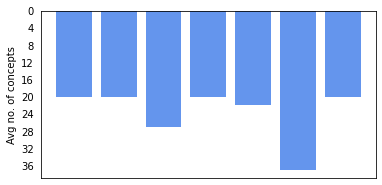

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plot_folder = "./plot_cub"
class_list = [
    "Expert1",
    "Expert2",
    "Expert3",
    "Expert4",
    "Expert5",
    "Expert6",
    ]
accuracy = [96, 92, 90, 80, 83, 77, 82]
avg_concept_used = [20, 20, 27, 20, 22, 37, 20]
cov = [0.17, 0.17, 0.16, 0.15, 0.12, 0.19]
fig = plt.figure()
ax = fig.add_subplot(111)
# increase space below subplot
fig.subplots_adjust(bottom=0.3)
ax.bar(class_list,
   avg_concept_used,
   width=0.8,
    color="#6495ED"
   )
# invert y axis
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_ylim([0,  20])
ax.invert_yaxis()
ax.set_ylabel("Avg no. of concepts")
# label x axis
# ax.set_xticks(range(len(df)))
# ax.set_xticklabels(df['x_cat'],
#                fontdict={'fontsize': 14})
plt.tick_params(left = False, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

resolution_value = 300
plt.savefig(os.path.join(plot_folder, "expert_concept_top_down.png"), format="png", dpi=resolution_value)
print(plot_folder)
plt.show()


./plot_cub


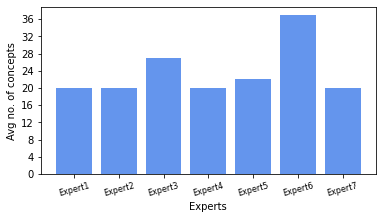

<IPython.core.display.Javascript object>

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig = plt.figure()
ax = fig.add_subplot(111)
# increase space below subplot
fig.subplots_adjust(bottom=0.3)
ax.bar(class_list, avg_concept_used, width=0.8, color="#6495ED")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_yticklabels([3, 6, 9, 12, 15, 18, 21])
# ax.set_ylim([0,  20])
# ax.invert_yaxis()
ax.set_ylabel("Avg no. of concepts")
ax.set_xlabel("Experts")
ax.set_xticks(range(len(class_list)))
ax.set_xticklabels(class_list, fontdict={"fontsize": 8})
# plt.tick_params(left = False, right = False , labelleft = True ,
#                 labelbottom = False, bottom = False)
for tick in ax.get_xticklabels():
    tick.set_rotation(15)

resolution_value = 300
plt.savefig(
    os.path.join(plot_folder, "expert_concept_botton_up.png"),
    format="png",
    dpi=resolution_value,
)
print(plot_folder)
plt.show()

./plot_cub


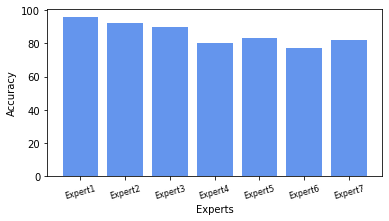

<IPython.core.display.Javascript object>

In [26]:
import pandas as pd
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111)
# increase space below subplot
fig.subplots_adjust(bottom=0.3)
ax.bar(class_list, accuracy, width=0.8, color="#6495ED")
# invert y axis
# ax.set_yticklabels([0, 3, 6, 9, 12, 15, 18, 21])
# ax.set_ylim([0,  20])
# ax.invert_yaxis()
ax.set_ylabel("Accuracy")
ax.set_xlabel("Experts")
# label x axis
ax.set_xticks(range(len(class_list)))
ax.set_xticklabels(class_list, fontdict={"fontsize": 8})
# plt.tick_params(left = False, right = False , labelleft = True ,
#                 labelbottom = False, bottom = False)
for tick in ax.get_xticklabels():
    tick.set_rotation(15)

resolution_value = 300
plt.savefig(
    os.path.join(plot_folder, "expert_acc_botton_up.png"),
    format="png",
    dpi=resolution_value,
)
print(plot_folder)
plt.show()